# Import Modules

In [1]:
import torch
import numpy
import pickle

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility functions for generating dataset

In [2]:
import random

# Generate a random operator (+ or -)
def get_operator():
    return random.choice(['+'])

# Generate a random coefficient (0-9)
def get_coeff():
    return random.randint(0, 9)

# Generate a random order (0-3) x*x*x
def get_order():
    return random.randint(0, 3)

# Generate a formulation with 5 terms
def get_formulation(n_terms=5):
    formulation = []
    for i in range(n_terms):
        term = (get_operator(), get_coeff(), get_order())
        formulation.append(term)
    return formulation

def term2str(term):
    operator, coeff, order = term
    term_str = ''
    term_str += operator
    term_str += str(coeff)
    order_repr = random.randint(0, order)
    order_repr = (order_repr, order - order_repr)
    pow_first = random.randint(0, 1)
    if pow_first:
        term_str += '*x'
        term_str += '^'
        term_str += str(order_repr[0])
        term_str += '*x' * order_repr[1]
    else:
        term_str += '*x' * order_repr[1]
        term_str += '*x'
        term_str += '^'
        term_str += str(order_repr[0])
    return term_str


def formulation2str(formulation):
    formulation_str = ''
    for term in formulation:
        formulation_str += term2str(term)
    return formulation_str[1:]

def aggregate_formulation(formulation):
    aggregated_formulation = []
    # sort formulation by order
    formulation.sort(key=lambda x: x[2], reverse=True)
    # aggregate formulation
    for term in formulation:
        operator, coeff, order = term
        if aggregated_formulation:
            if aggregated_formulation[-1][2] == order:
                aggregated_formulation[-1] = (operator, aggregated_formulation[-1][1] + coeff, order)
            else:
                aggregated_formulation.append(term)
        else:
            aggregated_formulation.append(term)
    return aggregated_formulation

def formulation2abvstr(aggregated_formulation):
    formulation_str = ''
    for term in aggregated_formulation:
        operator, coeff, order = term
        formulation_str += operator
        formulation_str += str(coeff)
        if order > 0:
            formulation_str += '*x'
            formulation_str += '^'
            formulation_str += str(order)
    return formulation_str[1:]

### Debug whether the output of formulations before and after the aggregation is the same

In [3]:
# Code for debugging

formulations = []
for i in range(1000):
    formulation = get_formulation()
    formulation_str = formulation2str(formulation)
    aggregated_formulation = aggregate_formulation(formulation)
    aggregated_formulation_str = formulation2abvstr(aggregated_formulation)
    formulations.append((formulation_str, aggregated_formulation_str))
# for formulation in formulations:
    # print(formulation)

def eval_str(formulation_str, x):
    return eval(formulation_str.replace('x', str(x)).replace('^', '**'))

for formulation in formulations:
    formulation_str, aggregated_formulation_str = formulation
    for x in range(0, 10):
        assert eval_str(formulation_str, x) == eval_str(aggregated_formulation_str, x), f'{formulation_str, aggregated_formulation_str, x}'

# Create dataset

In [4]:
def create_samples(formulation_str):
    return [eval_str(formulation_str, x) % 10 for x in range(0, 10)]

def create_database(n=1000000, n_terms=5):
    # database is a dictionary of formulation_abvstr -> samples
    # this function returns a list of (formulation_str, formulation_abvstr) and a dictionary of formulation_abvstr -> samples
    formulations = []
    database = {}
    for i in range(n):
        formulation = get_formulation(n_terms)
        formulation_str = formulation2str(formulation)
        aggregated_formulation = aggregate_formulation(formulation)
        aggregated_formulation_str = formulation2abvstr(aggregated_formulation)
        formulations.append((formulation_str, aggregated_formulation_str))
        if aggregated_formulation_str not in database:
            database[aggregated_formulation_str] = create_samples(formulation_str)
    return formulations, database

In [5]:
dataset = create_database()
with open('data/dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [6]:
with open('data/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

formulations, database = dataset

In [7]:
print(len(formulations), len(database))

1000000 78272


# debug all the samples in the saved file

In [8]:
for formulation_str, formulation_abvstr in formulations:
    assert formulation_abvstr in database
    assert (eval_str(formulation_str, 0)%10) == database[formulation_abvstr][0]
    assert (eval_str(formulation_str, 1)%10) == database[formulation_abvstr][1]
    assert (eval_str(formulation_str, 2)%10) == database[formulation_abvstr][2]
    assert (eval_str(formulation_str, 3)%10) == database[formulation_abvstr][3]
    assert (eval_str(formulation_str, 4)%10) == database[formulation_abvstr][4]
    assert (eval_str(formulation_str, 5)%10) == database[formulation_abvstr][5]
    assert (eval_str(formulation_str, 6)%10) == database[formulation_abvstr][6]
    assert (eval_str(formulation_str, 7)%10) == database[formulation_abvstr][7]
    assert (eval_str(formulation_str, 8)%10) == database[formulation_abvstr][8]
    assert (eval_str(formulation_str, 9)%10) == database[formulation_abvstr][9]

# Create a Tokenizer.
* 0-9
* '+' '*' '^' 'x'

In [9]:
from data.dataloader import get_tokenizer

In [10]:
tokenizer = get_tokenizer()

In [11]:
# encoded = tokenizer(formulation[0], padding='max_length', max_length=60, truncation=True, return_tensors='pt')
# encoded.input_ids.shape

# Create tokenized dataset
1. load pkl
2. save dataset of [full_str, abv_str, ys, x, y, full_tok, abv_tok, ys_tok, x_tok]

In [12]:
with open('data/dataset.pkl', 'rb') as f:
        data = pickle.load(f)
        forms, database = data

In [13]:
from tqdm import tqdm
dataset = []
for full, abv in tqdm(forms):
    ys = database[abv]
    x = random.randint(0, 9)
    y = ys[x]

    # append tokenized ones
    full_tok = tokenizer(full, padding=False, return_tensors='np', add_special_tokens=False).input_ids[0]
    abv_tok = tokenizer(abv, padding=False, return_tensors='np', add_special_tokens=False).input_ids[0]
    ys_tok = tokenizer(''.join([str(i) for i in ys]), padding=False, return_tensors='np', add_special_tokens=False).input_ids[0]
    x_tok = tokenizer(str(x), padding=False, return_tensors='np', add_special_tokens=False).input_ids[0]

    data = [full, abv, ys, x, y, full_tok, abv_tok, ys_tok, x_tok]
    dataset.append(data)

100%|██████████| 1000000/1000000 [03:54<00:00, 4265.89it/s]


In [14]:
print(full)
print(abv)
print(ys)
print(x)
print(y)
print(full_tok)
print(abv_tok)
print(ys_tok)
print(x_tok)

print(tokenizer.decode(full_tok, skip_special_tokens=False).replace(' ', ''))
print(tokenizer.decode(abv_tok, skip_special_tokens=False).replace(' ', ''))

8*x*x*x*x^0+9*x^1*x+4*x^0+3*x^0+9*x^1
8*x^3+9*x^2+9*x^1+7
[7, 3, 5, 1, 9, 7, 3, 5, 1, 9]
3
1
[14  3  5  3  5  3  5  3  5  4  6  1 15  3  5  4  7  3  5  1 10  3  5  4
  6  1  9  3  5  4  6  1 15  3  5  4  7]
[14  3  5  4  9  1 15  3  5  4  8  1 15  3  5  4  7  1 13]
[13  9 11  7 15 13  9 11  7 15]
[9]
8*x*x*x*x^0+9*x^1*x+4*x^0+3*x^0+9*x^1
8*x^3+9*x^2+9*x^1+7


In [15]:
with open('data/tokenized_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

# Create token Trie and save

In [16]:
from data.utils import Trie
with open('data/tokenized_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

identifiers = []
checker = set()

for full, abv, ys, x, y, full_tok, abv_tok, ys_tok, x_tok in dataset:
    abv_tok = abv_tok.tolist()
    abv_tok.append(tokenizer.eos_token_id)
    if abv not in checker:
        checker.add(abv)
        identifiers.append(abv_tok)


In [18]:
trie = Trie(tokenizer)
for key in identifiers:
    trie.insert(key)

In [ ]:
with open('data/trie.pkl', 'wb') as f:
    pickle.dump(trie, f)

In [ ]:
import matplotlib.pyplot as plt

def visualize_trie(trie):
    fig, ax = plt.subplots()
    ax.set_axis_off()

    def add_node(node, x, y, parent_x, parent_y, char):
        if node.is_end_of_word:
            circle = plt.Circle((x, y), radius=0.2, fill=False)
            ax.add_artist(circle)
            ax.text(x+0.2, y+0.2, char, ha='center', va='center')
        else:
            circle = plt.Circle((x, y), radius=0.05, fill=True)
            ax.add_artist(circle)
            ax.text(x+0.2, y+0.2, char, ha='center', va='center')
        if parent_x is not None and parent_y is not None:
            ax.plot([parent_x, x], [parent_y, y], 'k-')
        child_x = x - (len(node.children) - 1) / 2
        for child_char, child_node in node.children.items():
            add_node(child_node, child_x, y-1, x, y, child_char)
            child_x += 1

    add_node(trie.root, 0, 0, None, None, '')
    plt.show()

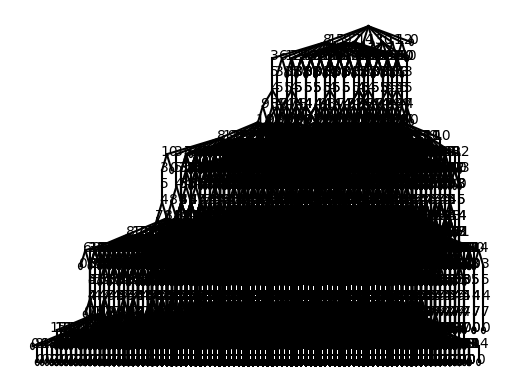

In [ ]:
visualize_trie(trie)

# split dataset into train, val, test

In [2]:
with open('data/tokenized_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

import random
random.shuffle(dataset)

dataset = dataset[:100000]

train = dataset[:int(len(dataset)*0.8)]
val = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test = dataset[int(len(dataset)*0.9):]

In [3]:
# save each split
with open('data/train.pkl', 'wb') as f:
    pickle.dump(train, f)
with open('data/val.pkl', 'wb') as f:
    pickle.dump(val, f)
with open('data/test.pkl', 'wb') as f:
    pickle.dump(test, f)